Dataset shape after processing: (494021, 41)
Optimal number of clusters found: 20


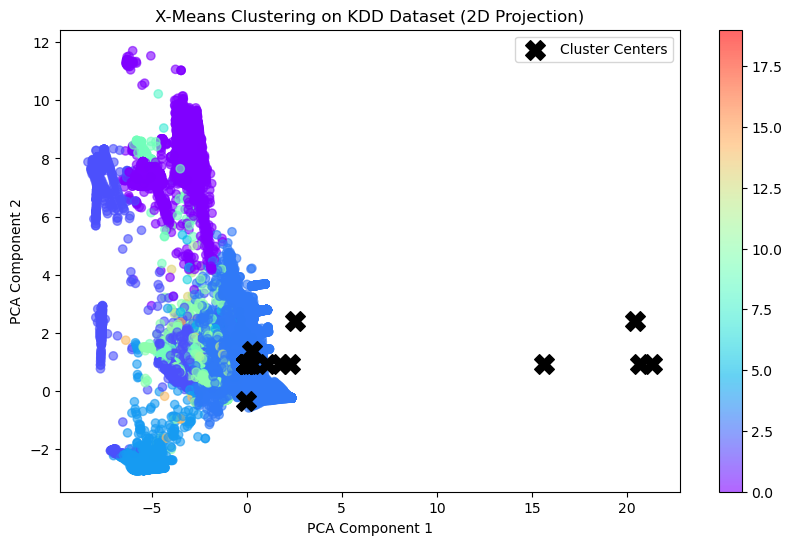

cluster
3.0     369388
4.0      86784
0.0      26726
10.0      5714
2.0       3461
9.0        771
5.0        455
12.0       389
11.0       293
14.0        13
13.0        11
16.0         4
1.0          3
6.0          2
19.0         2
7.0          1
18.0         1
17.0         1
15.0         1
8.0          1
Name: count, dtype: int64
Anomalous Clusters: []
   cluster  anomaly
0      3.0        0
1      3.0        0
2      3.0        0
3      3.0        0
4      3.0        0
5      3.0        0
6      3.0        0
7      3.0        0
8      3.0        0
9      3.0        0


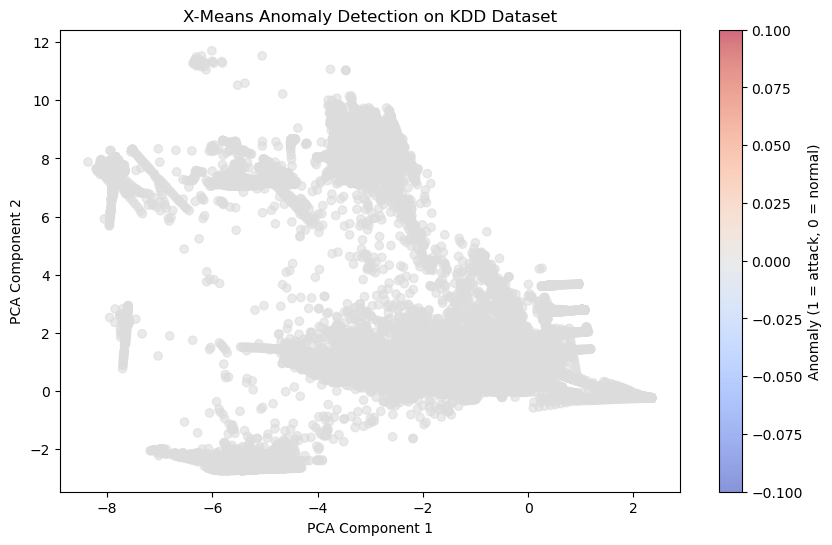

FileNotFoundError: [Errno 2] No such file or directory: 'kddcup.testdata.unlabeled_10_percent'

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer

import warnings
np.warnings = warnings

# Identify categorical features.
categorical_cols = ['protocol_type', 'service', 'flag']

# Load data into a DataFrame
df = pd.read_csv("kddcup.data_10_percent.gz", compression='gzip', header=None)

# df = df.sample(frac=0.1, replace=False) # Uncomment this line to sample less of the dataset

# The CSV file has no column heads, so add them.
df.columns = [
    'duration',
    'protocol_type',
    'service',
    'flag',
    'src_bytes',
    'dst_bytes',
    'land',
    'wrong_fragment',
    'urgent',
    'hot',
    'num_failed_logins',
    'logged_in',
    'num_compromised',
    'root_shell',
    'su_attempted',
    'num_root',
    'num_file_creations',
    'num_shells',
    'num_access_files',
    'num_outbound_cmds',
    'is_host_login',
    'is_guest_login',
    'count',
    'srv_count',
    'serror_rate',
    'srv_serror_rate',
    'rerror_rate',
    'srv_rerror_rate',
    'same_srv_rate',
    'diff_srv_rate',
    'srv_diff_host_rate',
    'dst_host_count',
    'dst_host_srv_count',
    'dst_host_same_srv_count',
    'dst_host_diff_srv_count',
    'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate',
    'dst_host_srv_serror_rate',
    'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate',
    'target'
]

# Drop any rows with missing values (if applicable)
df.dropna(inplace=True)

# Encode categorical variables
encoder = LabelEncoder()
for col in categorical_cols:
    df[col] = encoder.fit_transform(df[col])

# Drop the target label (attack type) for unsupervised learning
X = df.drop(columns=['target'])  # Unsupervised: No attack labels

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Dataset shape after processing: {X_scaled.shape}")

# Initialize centers
initial_centers = kmeans_plusplus_initializer(X_scaled, 2).initialize()

# Run X-Means Clustering
xmeans_instance = xmeans(X_scaled, initial_centers)
xmeans_instance.process()

# Get cluster results
clusters = xmeans_instance.get_clusters()
final_centers = xmeans_instance.get_centers()

print("Optimal number of clusters found:", len(clusters))

# Create an array to store cluster labels for each data point
cluster_labels = np.zeros(len(X_scaled))  

# Assign each point to its corresponding cluster
for cluster_idx, cluster_points in enumerate(clusters):
    for point_idx in cluster_points:
        cluster_labels[point_idx] = cluster_idx

# Reduce to 2D using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot Clusters
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='rainbow', alpha=0.6)
plt.scatter(np.array(final_centers)[:, 0], np.array(final_centers)[:, 1], c='black', marker='X', s=200, label='Cluster Centers')

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("X-Means Clustering on KDD Dataset (2D Projection)")
plt.legend()
plt.colorbar(scatter)
plt.show()

# Add clusters to original data frame.
df['cluster'] = cluster_labels

# Show distribution of points in each cluster
print(df['cluster'].value_counts())

# Find cluster sizes
cluster_sizes = df['cluster'].value_counts()

# Define threshold for "small" clusters
threshold = np.percentile(cluster_sizes, 20)  
anomalous_clusters = cluster_sizes[cluster_sizes < threshold].index.tolist()  # Clusters with < 100 points

print("Anomalous Clusters:", anomalous_clusters)

# Add anomaly column (1 if in an anomalous cluster, else 0)
df['anomaly'] = df['cluster'].apply(lambda x: 1 if x in anomalous_clusters else 0)

# Show some samples
print(df[['cluster', 'anomaly']].head(10))

# Visualize Anomalies in 2D
plt.figure(figsize=(10,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['anomaly'], cmap='coolwarm', alpha=0.6)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("X-Means Anomaly Detection on KDD Dataset")
plt.colorbar(label="Anomaly (1 = attack, 0 = normal)")
plt.show()

# Load test dataset
test_df = pd.read_csv("kddcup.testdata.unlabeled_10_percent", compression='gzip', header=None)

# Normalize using the same scaler from training
test_df = pd.DataFrame(scaler.transform(test_df), columns=test_df.columns)